### Set up Spark

In [2]:
#update local version of the package catalog
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.3.3
!wget -q https://archive.apache.org/dist/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
# unzip it
!tar xf spark-3.3.3-bin-hadoop3.tgz
# install findspark
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

import findspark
findspark.init()

## Task

In [4]:
import os
import gdown
import pandas as pd
import numpy as np
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import datetime
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
file_id = '1FDjEd0JdLayFcBvLC7wGq-09_zvvZ0C3'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'transactionrecord.csv'
gdown.download(download_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FDjEd0JdLayFcBvLC7wGq-09_zvvZ0C3
To: /content/transactionrecord.csv
100%|██████████| 44.6M/44.6M [00:00<00:00, 80.2MB/s]


'transactionrecord.csv'

In [6]:
sc = SparkContext.getOrCreate()

In [7]:
sqlContext = SQLContext(sc)

In [8]:
#load the data with specific format as csv
sdf = sqlContext.read.format('csv').option("header", True).load('transactionrecord.csv')

In [9]:
sdf.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

### Part 1

#### Question 1.1

In [10]:
#Question 1.1.1
print(f"The number of Nan values in 'CustomerNo' before filling: {sdf.filter(sdf['CustomerNo'].isNull()).count()}")
sdf = sdf.fillna({"CustomerNo": -1})
print(f"The number of Nan values in 'CustomerNo' after filling: {sdf.filter(sdf['CustomerNo'].isNull()).count()}")

The number of Nan values in 'CustomerNo' before filling: 0
The number of Nan values in 'CustomerNo' after filling: 0


In [11]:
#Question 1.1.2
@F.udf
def process_string(x, keep_space = True):
    return re.sub(r'[^a-zA-Z\s]' if keep_space is True else r'[^a-zA-Z\s]', '', x)

sdf = sdf.withColumn("productName_process", process_string(sdf["productName"]))
sdf.select('productName_process').show(5)

+--------------------+
| productName_process|
+--------------------+
|Set Of  Wooden Ma...|
|Christmas Star Wi...|
|Storage Tin Vinta...|
|Tree TLight Holde...|
|Set Of  Knick Kna...|
+--------------------+
only showing top 5 rows



#### Question 1.2

In [12]:
#Question 1.2.1
sdf = sdf.withColumn("revenue", (F.col("price") * F.col("Quantity")).cast("float"))
sdf.select("price", "Quantity", "revenue").show(5)

+-----+--------+-------+
|price|Quantity|revenue|
+-----+--------+-------+
|21.47|      12| 257.64|
|10.65|      36|  383.4|
|11.53|      12| 138.36|
|10.65|      12|  127.8|
|11.94|       6|  71.64|
+-----+--------+-------+
only showing top 5 rows



In [ ]:
#Question 1.2.2
df = sdf.toPandas()
df['transaction_date'] = pd.to_datetime(df['Date'])
df[['Date', 'transaction_date']].head(5)

In [ ]:
#Question 1.2.3
df.groupby('transaction_date')['revenue'].sum().plot(kind='line', ylabel = 'Sum of revenue', grid=True)

### Part 2

#### Question 2.1

In [ ]:
df_group = df.groupby('transaction_date').agg({'revenue': 'sum'}).reset_index()
max_date, min_date = df_group['transaction_date'].max(), df_group['transaction_date'].min()
fill_revenue_value = df_group['revenue'].mean()
available_date = {each: df_group['revenue'][i] for i, each in enumerate(df_group['transaction_date'])}

In [ ]:
added_days, count_unavailable_days = 0, 0
while True:
    current_date = min_date + pd.Timedelta(days= added_days)
    if current_date == max_date:
        break
    if current_date not in available_date:
        count_unavailable_days += 1
        available_date[current_date] = fill_revenue_value
    added_days += 1

print(f"The number of unavailable day: {count_unavailable_days}")

In [ ]:
filled_df = pd.DataFrame(data = {"transaction_date": list(available_date.keys()),
                                 "revenue": list(available_date.values())}).sort_values(by=["transaction_date"]).reset_index(drop=True)
filled_df.index = filled_df['transaction_date']
#set the frequency of index to 'day'
filled_df.index.freq = 'D'
filled_df = filled_df[['revenue']]
filled_df.head(5)

In [ ]:
decompose_result = seasonal_decompose(filled_df['revenue'], model='additive', period=7)

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
decompose_result.plot()
plt.show()

In [ ]:
def model_evaluation(df, p=0, q=0, d=0, period_step = 1, start_date = None, max_date = None):
    start_date = df.index.min() if start_date is None else pd.to_datetime(start_date)
    current_date = start_date
    max_date = df.index.max() if max_date is None else pd.to_datetime(max_date) #the last day of the data
    predictions = []
    while current_date <= max_date:
        train_data = df[df.index < current_date]
        model = ARIMA(train_data, order=(p, d, q))
        try:
            result = model.fit().forecast(steps = period_step)
        except:
            result = train_data.mean()
        predictions.append(result.values)
        current_date += pd.Timedelta(days = period_step)
    #transform predictions to 1-d numpy array
    predictions = np.concatenate(predictions, axis=0)
    groundtruth = filled_df[(filled_df.index >= start_date) & (filled_df.index <= max_date)].values
    return mean_absolute_error(groundtruth, predictions)

In [ ]:
list_p, list_q, list_d, list_mae = [], [], [], []

def grid_search_hyperparams(list_hyperparams):
    if len(list_hyperparams) == 3:
        p, q, d = list_hyperparams
        list_p.append(p)
        list_q.append(q)
        list_d.append(d)
        mae_res = model_evaluation(filled_df, p, q, d, start_date = '2019-01-01', max_date = '2019-11-01')
        list_mae.append(mae_res)
        return
    for i in range(3):
        list_hyperparams.append(i)
        grid_search_hyperparams(list_hyperparams.copy())
        list_hyperparams = list_hyperparams[:-1]

grid_search_hyperparams([])

In [82]:
df_result = pd.DataFrame(data = {'p': list_p, 'q': list_q, 'd': list_d, 'MAE': list_mae})
df_result.sort_values(by='MAE').reset_index(drop=True).head(10)

,p,q,d,MAE
0,0,0,2,56809.033903
1,0,0,2,56809.033903
2,0,0,2,56809.033903
3,0,0,0,57509.757277
4,0,0,1,57536.312411
5,0,0,1,57536.312411
6,0,0,1,57536.312411


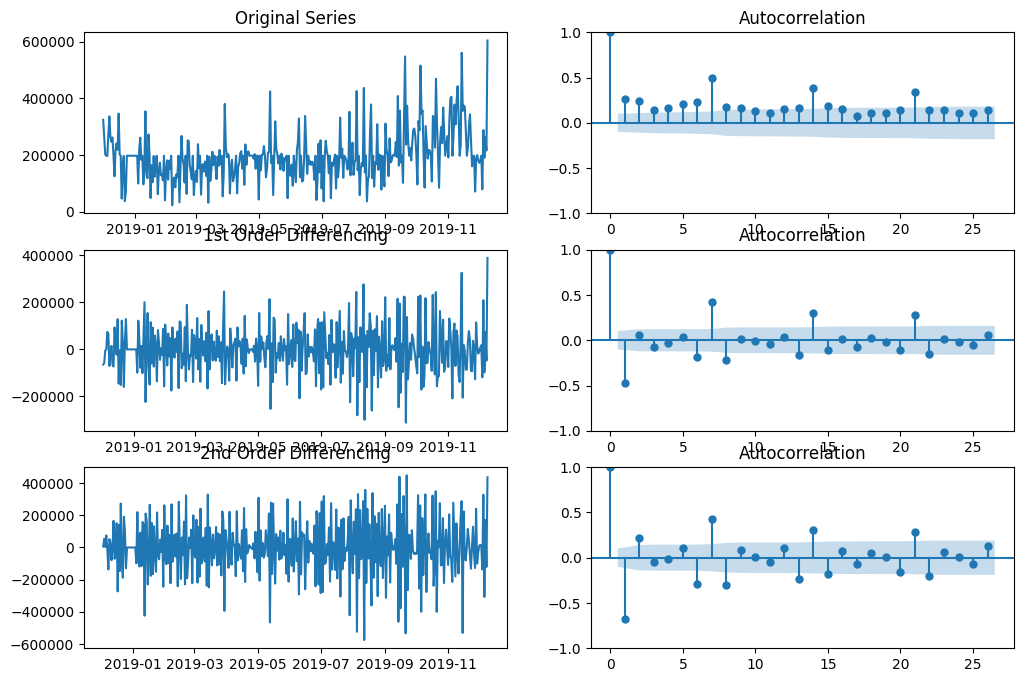

In [19]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(filled_df.revenue); axes[0, 0].set_title('Original Series')
plot_acf(filled_df.revenue, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(filled_df.revenue.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(filled_df.revenue.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(filled_df.revenue.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(filled_df.revenue.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

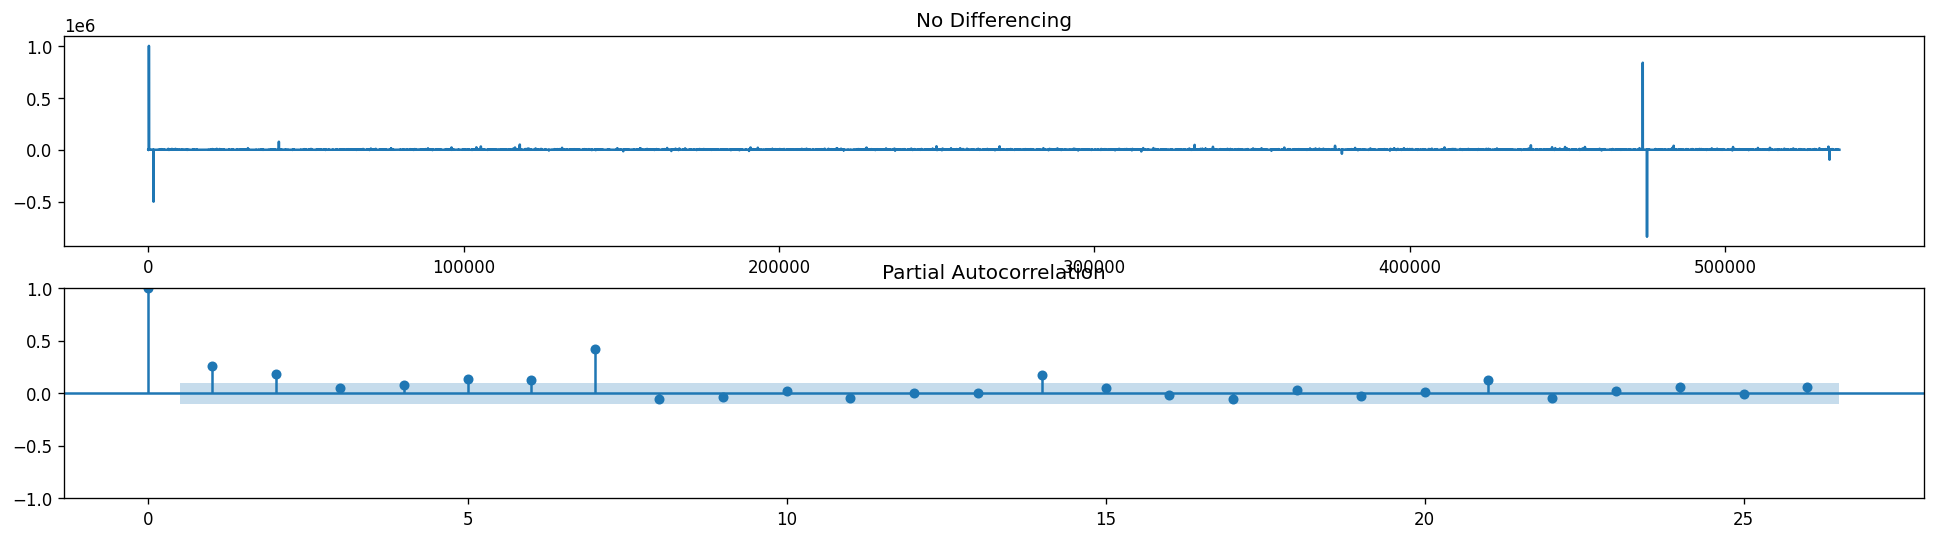

In [20]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1)
axes[0].plot(df.revenue); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(filled_df.revenue, ax=axes[1])

plt.show()